# Python可视化

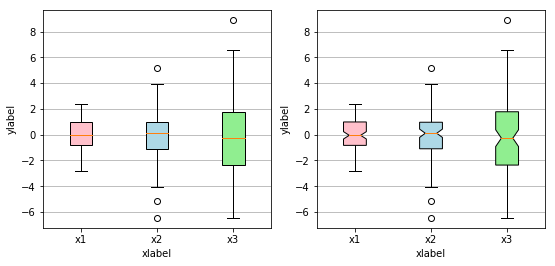

In [1]:
"""
=================================
Box plots with custom fill colors
=================================

This plot illustrates how to create two types of box plots
(rectangular and notched), and how to fill them with custom
colors by accessing the properties of the artists of the
box plots. Additionally, the ``labels`` parameter is used to
provide x-tick labels for each sample.

A good general reference on boxplots and their history can be found
here: http://vita.had.co.nz/papers/boxplots.pdf
"""

import matplotlib.pyplot as plt
import numpy as np

# Random test data
np.random.seed(123)
all_data = [np.random.normal(0, std, 100) for std in range(1, 4)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# rectangular box plot
bplot1 = axes[0].boxplot(all_data,
                         vert=True,   # vertical box aligmnent
                         patch_artist=True)   # fill with color

# notch shape box plot
bplot2 = axes[1].boxplot(all_data,
                         notch=True,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True)   # fill with color

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))], )
    ax.set_xlabel('xlabel')
    ax.set_ylabel('ylabel')

# add x-tick labels
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=['x1', 'x2', 'x3', 'x4'])

plt.show()

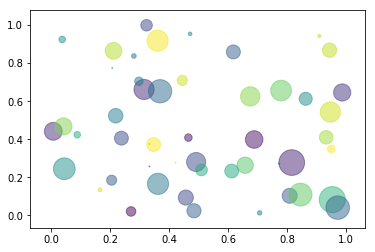

In [4]:
"""
Simple demo of a scatter plot.
"""
import numpy as np
import matplotlib.pyplot as plt


N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = np.pi * (15 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

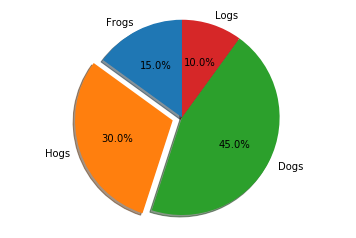

In [2]:
"""
===============
Basic pie chart
===============

Demo of a basic pie chart plus a few additional features.

In addition to the basic pie chart, this demo shows a few optional features:

    * slice labels
    * auto-labeling the percentage
    * offsetting a slice with "explode"
    * drop-shadow
    * custom start angle

Note about the custom start angle:

The default ``startangle`` is 0, which would start the "Frogs" slice on the
positive x-axis. This example sets ``startangle = 90`` such that everything is
rotated counter-clockwise by 90 degrees, and the frog slice starts on the
positive y-axis.
"""
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

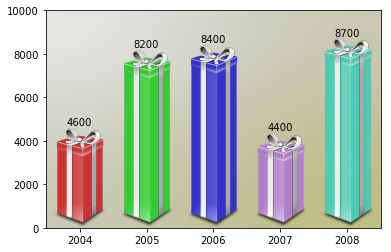

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.image import BboxImage

from matplotlib._png import read_png
import matplotlib.colors
from matplotlib.cbook import get_sample_data


class RibbonBox(object):

    original_image = read_png(get_sample_data("Minduka_Present_Blue_Pack.png",
                                              asfileobj=False))
    cut_location = 70
    b_and_h = original_image[:, :, 2]
    color = original_image[:, :, 2] - original_image[:, :, 0]
    alpha = original_image[:, :, 3]
    nx = original_image.shape[1]

    def __init__(self, color):
        rgb = matplotlib.colors.to_rgba(color)[:3]

        im = np.empty(self.original_image.shape,
                      self.original_image.dtype)

        im[:, :, :3] = self.b_and_h[:, :, np.newaxis]
        im[:, :, :3] -= self.color[:, :, np.newaxis]*(1. - np.array(rgb))
        im[:, :, 3] = self.alpha

        self.im = im

    def get_stretched_image(self, stretch_factor):
        stretch_factor = max(stretch_factor, 1)
        ny, nx, nch = self.im.shape
        ny2 = int(ny*stretch_factor)

        stretched_image = np.empty((ny2, nx, nch),
                                   self.im.dtype)
        cut = self.im[self.cut_location, :, :]
        stretched_image[:, :, :] = cut
        stretched_image[:self.cut_location, :, :] = \
            self.im[:self.cut_location, :, :]
        stretched_image[-(ny - self.cut_location):, :, :] = \
            self.im[-(ny - self.cut_location):, :, :]

        self._cached_im = stretched_image
        return stretched_image


class RibbonBoxImage(BboxImage):
    zorder = 1

    def __init__(self, bbox, color,
                 cmap=None,
                 norm=None,
                 interpolation=None,
                 origin=None,
                 filternorm=1,
                 filterrad=4.0,
                 resample=False,
                 **kwargs
                 ):

        BboxImage.__init__(self, bbox,
                           cmap=cmap,
                           norm=norm,
                           interpolation=interpolation,
                           origin=origin,
                           filternorm=filternorm,
                           filterrad=filterrad,
                           resample=resample,
                           **kwargs
                           )

        self._ribbonbox = RibbonBox(color)
        self._cached_ny = None

    def draw(self, renderer, *args, **kwargs):

        bbox = self.get_window_extent(renderer)
        stretch_factor = bbox.height / bbox.width

        ny = int(stretch_factor*self._ribbonbox.nx)
        if self._cached_ny != ny:
            arr = self._ribbonbox.get_stretched_image(stretch_factor)
            self.set_array(arr)
            self._cached_ny = ny

        BboxImage.draw(self, renderer, *args, **kwargs)


if 1:
    from matplotlib.transforms import Bbox, TransformedBbox
    from matplotlib.ticker import ScalarFormatter

    fig, ax = plt.subplots()

    years = np.arange(2004, 2009)
    box_colors = [(0.8, 0.2, 0.2),
                  (0.2, 0.8, 0.2),
                  (0.2, 0.2, 0.8),
                  (0.7, 0.5, 0.8),
                  (0.3, 0.8, 0.7),
                  ]
    heights = np.random.random(years.shape) * 7000 + 3000

    fmt = ScalarFormatter(useOffset=False)
    ax.xaxis.set_major_formatter(fmt)

    for year, h, bc in zip(years, heights, box_colors):
        bbox0 = Bbox.from_extents(year - 0.4, 0., year + 0.4, h)
        bbox = TransformedBbox(bbox0, ax.transData)
        rb_patch = RibbonBoxImage(bbox, bc, interpolation="bicubic")

        ax.add_artist(rb_patch)

        ax.annotate(r"%d" % (int(h/100.)*100),
                    (year, h), va="bottom", ha="center")

    patch_gradient = BboxImage(ax.bbox,
                               interpolation="bicubic",
                               zorder=0.1,
                               )
    gradient = np.zeros((2, 2, 4), dtype=np.float)
    gradient[:, :, :3] = [1, 1, 0.]
    gradient[:, :, 3] = [[0.1, 0.3], [0.3, 0.5]]  # alpha channel
    patch_gradient.set_array(gradient)
    ax.add_artist(patch_gradient)

    ax.set_xlim(years[0] - 0.5, years[-1] + 0.5)
    ax.set_ylim(0, 10000)

    fig.savefig('ribbon_box.png')
    plt.show()